In [80]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

import azureml.core
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core import Dataset
from azureml.core import Run

In [5]:
#connect to workspace
ws = Workspace.from_config()

In [65]:
#give a name to experiment
experiment_name = "credit-card-fraud-detection"
experiment = Experiment(workspace = ws, name = experiment_name)

In [66]:
#get the registered dataset
dataset = Dataset.get_by_name(ws, name='credit_card_fraud_data')
data = dataset.to_pandas_dataframe()

In [67]:
dimensions = data.shape
dimensions

(284807, 30)

In [68]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<BarContainer object of 2 artists>

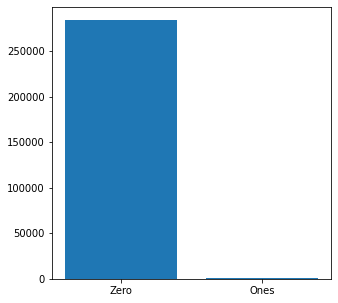

In [69]:
names = ['Zero', 'Ones']
values = data['Class'].value_counts().values

freq_plot = plt.figure(figsize=(5, 5))

#plt.subplot(131)
plt.bar(names, values)

In [70]:
x = data.drop(['Class'], axis=1)
y = data['Class']

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size = 0.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

In [72]:
C_param_range = [0.001,0.01,0.1,1,10,100]

for c in C_param_range:
    run = experiment.start_logging()
    run.log("C_value", c)
    
    model = LogisticRegression(penalty = 'l2', C = c, random_state = 0)
    model.fit(x_train,y_train)
    
    # Predict using model
    y_pred = model.predict_proba(x_test)[:,1]
    
    auc_roc = roc_auc_score(y_test, y_pred)*100
    run.log("auc_roc", auc_roc)
    
    model_name = "model_c_" + str(c) + ".pkl"
    filename = "outputs/" + model_name
    
    joblib.dump(value=model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    run.complete()

In [77]:
#show the experiment which has just run
experiment

Name,Workspace,Report Page,Docs Page
credit-card-fraud-detection,aml-docs2,Link to Azure Machine Learning studio,Link to Documentation


In [76]:
#get the best model
max_auc_roc_runid = None
max_auc_roc = None

for run in experiment.get_runs():
    run_metrics = run.get_metrics()
    run_details = run.get_details()
    # each logged metric becomes a key in this returned dict
    run_auc_roc = run_metrics["auc_roc"]
    run_id = run_details["runId"]
    
    if max_auc_roc is None:
        max_auc_roc = run_auc_roc
        max_auc_roc_runid = run_id
    else:
        if run_auc_roc > max_auc_roc:
            max_auc_roc = run_auc_roc
            max_auc_roc_runid = run_id

print("Best run_id: " + max_auc_roc_runid)
print("Best run_id auc_roc: " + str(max_auc_roc))    

Best run_id: 3a50d151-7004-4cb4-9d58-9d5fde0ac8b7
Best run_id auc_roc: 96.87273896615483


In [81]:
best_run = Run(experiment=experiment, run_id=max_auc_roc_runid)
print(best_run.get_file_names())

['model_c_0.1.pkl']


In [85]:
#register the best model
model = best_run.register_model(model_name='credit_card_moddel', model_path='model_c_0.1.pkl')
print(model.name, model.id, model.version, sep='\t')

credit_card_moddel	credit_card_moddel:1	1
